# Reconocimiento de patrones: Identificación de grupos o Clustering
### Ramón Soto C. [(rsotoc@moviquest.com)](mailto:rsotoc@moviquest.com/)
![ ](images/blank.png)
![agents](images/binary_data_under_a_magnifying.jpg)
[ver en nbviewer](http://nbviewer.ipython.org/github/rsotoc/pattern-recognition/blob/master/Clustering%20IV.ipynb)

## Técnicas de clustering: *DBSCAN*

... Otro problema de la técnica de clustering *k-medias*, es que asume una forma convexa de los conjuntos. Considérese por ejemplo la siguiente... 

La técnica de *k-medias* (o *k-means*) es una de las técnicas de clustering más simples y más utilizadas; es una técnica muy simple y rápida. Sin embargo, esta técnica sufre de tres limitantes importantes: a) escala pobre computacionalmente, b) su eficacia es fuertemente dependiente de la selección de $k$ pudiendo caer en mínimos locales y c) el valor de $k$ debe ser proporcioando por el usuario y no puede modificarse una vez que inicia el proceso. 


### Parámetros



In [1]:
# Inicializar el ambiente
import numpy as np
import pandas as pd
#import math
#import random
#import time
#from scipy.spatial import distance
#np.set_printoptions(precision=2, suppress=True) # Cortar la impresión de decimales a 1
from sklearn import cluster

from sklearn import metrics
#from sklearn.datasets.samples_generator import make_blobs
#from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
%matplotlib inline

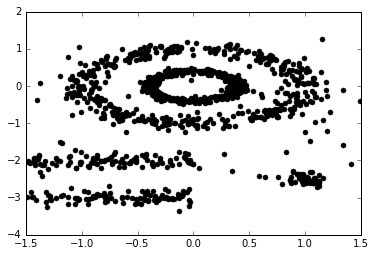

In [30]:
multishapes = pd.read_csv("Data sets/Factoextra/multishapes_raw.csv").values
plt.plot(multishapes[:, 0], multishapes[:, 1], 'o', 
         markeredgecolor='0', markerfacecolor='0', markersize=5)
plt.show()

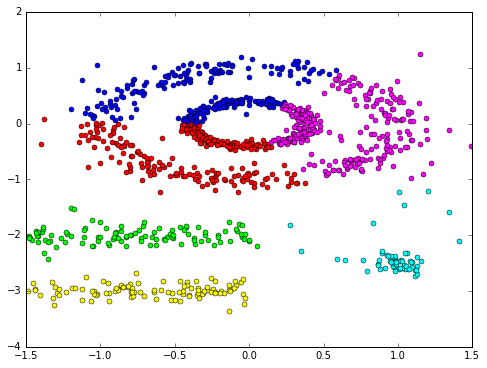

In [2]:
multishapes = pd.read_csv("Data sets/Factoextra/multishapes_raw.csv").values

num_clusters = 6
k_means = cluster.KMeans(n_clusters=num_clusters, init='random')
k_means.fit(multishapes)

fig = plt.figure(figsize=(8, 6))
colors = ['#ff0000', '#00ff00', '#0000ff', '#ff00ff', '#00ffff', '#ffff00']
for k in range(num_clusters):
    my_members = k_means.labels_ == k
    plt.plot(multishapes[my_members, 0], multishapes[my_members, 1], 'o', 
             markeredgecolor='k', markerfacecolor=colors[k], markersize=5)

![](images/k-means5.png)


{0, 1, 2, 3, -1}


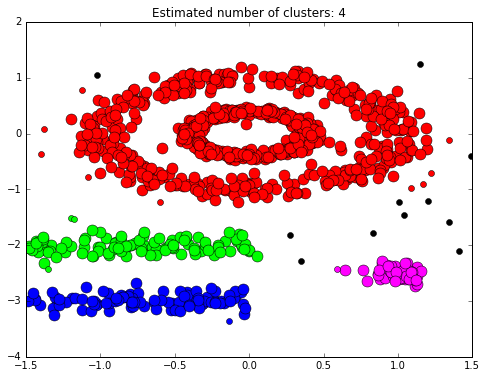

In [22]:
db = cluster.DBSCAN(eps=0.3, min_samples=10)
db.fit(multishapes)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
unique_labels = set(db.labels_)

print(unique_labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in db.labels_ else 0)

fig = plt.figure(figsize=(8, 6))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    my_members = db.labels_ == k

    xy = multishapes[my_members & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col, markeredgecolor='k', markersize=11)

    xy = multishapes[my_members & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col, markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

El método ISODATA es un método poco utilizado fuera del área de procesamiento de imágenes. Es difícil de configurar, por la cantidad y naturaleza de los parámetros a definir.

<hr style="border-width: 3px;">

### Tarea 7

* Generar un programa integrado del método ISODATA 

* Aplicar los elementos vistos en clase hasta el momento a un conjunto de datos de su preferencia

**Fecha de entrega**: Martes 20 de septiembre.